In [110]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from qbo1d.stochastic_forcing import sample_sf_cw

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
def ax_pos_inch_to_absolute(fig_size, ax_pos_inch):
    ax_pos_absolute = []
    ax_pos_absolute.append(ax_pos_inch[0]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[1]/fig_size[1])
    ax_pos_absolute.append(ax_pos_inch[2]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[3]/fig_size[1])
    
    return ax_pos_absolute

In [112]:
def plot_76_tensors(u, solver, amp25=None, amp20=None, period=None, isu=True):
    fig_size = (06.90, 02.20+01.50)
    fig = plt.figure(figsize=fig_size)

    ax = []

    ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

    cmin = -u.abs().max()
    cmax = u.abs().max()
    print(cmin)
    print(cmax)

    xmin = 84.
    xmax = 96.
    ymin = 17.
    ymax = 35.

    ax[0].set_xlim(left=84.)
    ax[0].set_xlim(right=96.)
    ax[0].set_ylim(bottom=17.)
    ax[0].set_ylim(top=35.)

    h = []

    h.append(ax[0].contourf(solver.time/86400/360, solver.z/1000, u.T,
                21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

    
    ax[0].set_ylabel('Km', fontsize=10)

    ax[0].set_xlabel('model year', fontsize=10)

    # Set ticks
    xticks_list = np.arange(xmin, xmax+1, 1)
    ax[0].set_xticks(xticks_list)

    yticks_list = np.arange(ymin, ymax+2, 2)
    ax[0].set_yticks(yticks_list)

    xticklabels_list = list(xticks_list)
    xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
    ax[0].set_xticklabels(xticklabels_list, fontsize=10)

    ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
    ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

    ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
    ax[0].tick_params(which='both', labelbottom=True)

    # if u, the display \tau and \sigma
    if isu:
        ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
        ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

        ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %period + 'months',
        horizontalalignment='left', verticalalignment='bottom', color='black')

    # The label it displays
    # u/s has different dimension
    if isu:
        label = r'$\mathrm{m s^{-1}}$'
    else:
        label = r'$\mathrm{m s^{-2}}$'
    
    # Color bars
    if isu:
        cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
        ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
        boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
        label=label)
    else:
        cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
        ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% .2e', 
        boundaries=np.linspace(cmin, cmax, 11), orientation='horizontal',
        label=label)

# Generate/Load the standard model

## Load the data (or generate it with the PDE solver) 

In [123]:
# To save some time, we use the preloaded data
u = np.load('/Users/eddysmac/Desktop/QBO-Research/qbo1d/u.npy')
s = np.load('/Users/eddysmac/Desktop/QBO-Research/qbo1d/s.npy')
sf = np.load('/Users/eddysmac/Desktop/QBO-Research/qbo1d/sf.npy')
cw = np.load('/Users/eddysmac/Desktop/QBO-Research/qbo1d/cw.npy')

nsteps = 360 * 108
nspinup = 360 * 12

u = u[nspinup:nsteps, :]
s = s[nspinup:nsteps, :]
cw = cw[nspinup:nsteps]
sf = sf[nspinup:nsteps]

# train-test split
# test_size = 0.2

U = np.hstack([u, sf.reshape(-1, 1), cw.reshape(-1, 1)])
print(f"The shape of data U is {U.shape}")

# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

The shape of data U is (34560, 75)


## Generate the Linear Models
- Take the linear regression with $(U, sf, cw)$.


In [124]:
reg = LinearRegression()
reg.fit(U_train, s_train)
reg.score(U_test, s_test)

0.8927183097738166

# Perturbation

## Peturbation matrix
Each row represents a state
- state = 0: the control case
- state = 1: biased means
- state = 2: biased variance
- state = 3: anti-correlated fluxes and spectral width


In [125]:
sfe = [3.8e-3, 3.2e-3, 3.8e-3, 3.8e-3]
sfv = [1e-8, 9e-8, 9e-10, 9e-8]
cwe = [32, 40, 32, 32]
cwv = [225, 225, 225, 225]
corr = [0.75, 0.75, 0.75, -0.75]
seed = [int(21*9+7), int(21*6+15), int(21*12+5), int(21*2+10)]

# generate the matrix form

pert_mat = np.array([sfe, sfv, cwe, cwv, corr, seed]).T

print("Parameters: \n", pert_mat)

Parameters: 
 [[ 3.80e-03  1.00e-08  3.20e+01  2.25e+02  7.50e-01  1.96e+02]
 [ 3.20e-03  9.00e-08  4.00e+01  2.25e+02  7.50e-01  1.41e+02]
 [ 3.80e-03  9.00e-10  3.20e+01  2.25e+02  7.50e-01  2.57e+02]
 [ 3.80e-03  9.00e-08  3.20e+01  2.25e+02 -7.50e-01  5.20e+01]]


## Use the PDE solver to solve the purterbed cases

In [126]:
# Specify the purterbed state
STATE = 0

In [127]:
# use adsolver to solve the perturbed case
t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver, *pert_mat[STATE]) 
time = solver.time
z_p = solver.z
u_p = solver.solve(source_func=model)
cw_p, sf_p = model.cw, model.sf


In [118]:
spinup_time = 12*360*86400

amp25 = utils.estimate_amplitude(solver.time, solver.z, u_p, height=25e3, spinup=spinup_time)
amp20 = utils.estimate_amplitude(solver.time, solver.z, u_p, height=20e3, spinup=spinup_time)
tau25 = utils.estimate_period(solver.time, solver.z, u_p, height=25e3, spinup=spinup_time)

### Visualization

tensor(-74.2398)
tensor(74.2398)


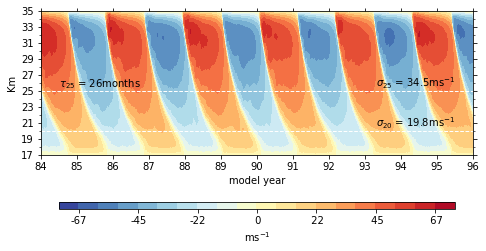

In [119]:
plot_76_tensors(u_p, solver=solver, amp25=amp25, amp20=amp20, period=tau25, isu=True)

# Use the linear model to predict the perturbation case

## OFFLINE performance

## ONLINE testing

In [132]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], sfe=3.8e-3, sfv=1e-8, cwe=32, cwv=225, corr=0.75, seed=int(21*9+8))

model_ML_aug = lambda x : torch.tensor(reg.coef_) @ torch.hstack([x, sf_ML[solver_ML.current_step], cw_ML[solver_ML.current_step]]) + torch.tensor(reg.intercept_)


u_ML = solver_ML.solve(source_func=model_ML_aug)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [133]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

tensor(-82573.1351)
tensor(82573.1351)


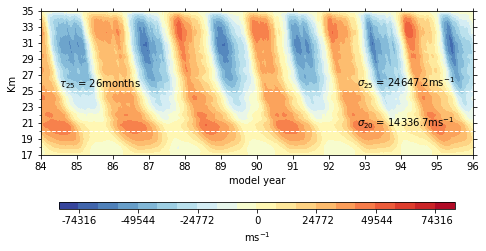

In [134]:
plot_76_tensors(u_ML, solver_ML, amp25=amp25_ML, amp20=amp20_ML, period=tau25_ML, isu=True)

The model doesn't work after the perturbation